### Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import networkx as nx

from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import remove_isolated_nodes, to_networkx

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from Graph_Nets import GCNetwork, GANetwork

### Dataset

In [2]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the Dataset
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: CiteSeer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [3]:
isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


In [4]:
print(data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [5]:
g = to_networkx(data)
order = sorted(list(g.nodes()))
A = nx.adjacency_matrix(g, nodelist=order)
A = A.todense()
I = np.eye(A.shape[0])
A = A + I

In [6]:
X, y, A = torch.Tensor(data.x), torch.Tensor(data.y), torch.Tensor(A)

In [7]:
X.shape, y.shape, A.shape

(torch.Size([3327, 3703]), torch.Size([3327]), torch.Size([3327, 3327]))

### Training

In [8]:
in_features = data.x.size(1)
out_features = 30
n_classes = dataset.num_classes
num_heads = 4
bias = True
alpha = 0.2

#### Graph Convolutional Network

In [9]:
GCN = GCNetwork(in_features=in_features, 
                out_features=out_features, 
                n_classes=n_classes, 
                bias=bias)

In [10]:
num_epochs = 30
lr_rate=0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr_rate)

In [11]:
a, b = GCN(X, A)
a.shape, b.shape

(torch.Size([3327, 30]), torch.Size([3327, 6]))

In [12]:
train_epoch_losses, val_epoch_losses = [], []
train_epoch_acc, val_epoch_acc = [], []

for epoch in range(num_epochs):
    GCN.train()
    _, preds = GCN(X, A)
    loss = loss_fn(preds[data.train_mask], data.y[data.train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc = float((torch.argmax(F.softmax(preds[data.train_mask], dim=1), axis=1) == data.y[data.train_mask]).sum() / data.y[data.train_mask].shape[0])

    val_loss = loss_fn(preds[data.val_mask], data.y[data.val_mask])
    val_acc = float((torch.argmax(F.softmax(preds[data.val_mask], dim=1), axis=1) == data.y[data.val_mask]).sum() / data.y[data.val_mask].shape[0])

    train_epoch_losses.append(loss.item())
    val_epoch_losses.append(val_loss.item())
    train_epoch_acc.append(acc)
    val_epoch_acc.append(val_acc)

    print(f'Epoch: {epoch+1} | train loss: {loss.item():.6f} | train accuracy: {acc:.3f} | val loss: {val_loss.item():.3f} | val accuracy {val_acc:.3f}')

Epoch: 1 | train loss: 1.799781 | train accuracy: 0.100 | val loss: 1.814 | val accuracy 0.160
Epoch: 2 | train loss: 1.682518 | train accuracy: 0.483 | val loss: 1.780 | val accuracy 0.298
Epoch: 3 | train loss: 1.486944 | train accuracy: 0.792 | val loss: 1.711 | val accuracy 0.364
Epoch: 4 | train loss: 1.256579 | train accuracy: 0.892 | val loss: 1.637 | val accuracy 0.436
Epoch: 5 | train loss: 1.025135 | train accuracy: 0.950 | val loss: 1.566 | val accuracy 0.506
Epoch: 6 | train loss: 0.806487 | train accuracy: 0.975 | val loss: 1.495 | val accuracy 0.558
Epoch: 7 | train loss: 0.610375 | train accuracy: 0.992 | val loss: 1.425 | val accuracy 0.592
Epoch: 8 | train loss: 0.444174 | train accuracy: 1.000 | val loss: 1.361 | val accuracy 0.606
Epoch: 9 | train loss: 0.311086 | train accuracy: 1.000 | val loss: 1.306 | val accuracy 0.614
Epoch: 10 | train loss: 0.210224 | train accuracy: 1.000 | val loss: 1.260 | val accuracy 0.612
Epoch: 11 | train loss: 0.138091 | train accuracy

#### Graph Attantion Network

In [13]:
GAN = GANetwork(in_features=in_features, 
                out_features=out_features, 
                n_classes=n_classes, 
                num_heads=num_heads, 
                alpha=alpha, 
                bias=bias)

In [14]:
num_epochs = 30
lr_rate=0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GAN.parameters(), lr=lr_rate)

In [15]:
X, A = X.unsqueeze(axis=0), A.unsqueeze(axis=0)

In [16]:
train_epoch_losses2, val_epoch_losses2 = [], []
train_epoch_acc2, val_epoch_acc2 = [], []

for epoch in range(num_epochs):
    _, preds = GAN(X, A)
    loss = loss_fn(preds.squeeze(axis=0)[data.train_mask], data.y[data.train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc = float((torch.argmax(F.softmax(preds.squeeze(axis=0)[data.train_mask], dim=1), axis=1) == data.y[data.train_mask]).sum() / data.y[data.train_mask].shape[0])

    val_loss = loss_fn(preds.squeeze(axis=0)[data.val_mask], data.y[data.val_mask])
    val_acc = float((torch.argmax(F.softmax(preds.squeeze(axis=0)[data.val_mask], dim=1), axis=1) == data.y[data.val_mask]).sum() / data.y[data.val_mask].shape[0])

    train_epoch_losses2.append(loss.item())
    val_epoch_losses2.append(val_loss.item())
    train_epoch_acc2.append(acc)
    val_epoch_acc2.append(val_acc)

    print(f'Epoch: {epoch+1} | train loss: {loss.item():.3f} | train accuracy: {acc:.3f} | val loss: {val_loss.item():.3f} | val accuracy {val_acc:.3f}')

Epoch: 1 | train loss: 1.796 | train accuracy: 0.167 | val loss: 1.803 | val accuracy 0.188
Epoch: 2 | train loss: 1.773 | train accuracy: 0.167 | val loss: 1.792 | val accuracy 0.188
Epoch: 3 | train loss: 1.749 | train accuracy: 0.258 | val loss: 1.780 | val accuracy 0.190
Epoch: 4 | train loss: 1.721 | train accuracy: 0.583 | val loss: 1.767 | val accuracy 0.230
Epoch: 5 | train loss: 1.688 | train accuracy: 0.900 | val loss: 1.753 | val accuracy 0.394
Epoch: 6 | train loss: 1.649 | train accuracy: 0.967 | val loss: 1.738 | val accuracy 0.600
Epoch: 7 | train loss: 1.605 | train accuracy: 0.958 | val loss: 1.720 | val accuracy 0.674
Epoch: 8 | train loss: 1.555 | train accuracy: 0.950 | val loss: 1.700 | val accuracy 0.676
Epoch: 9 | train loss: 1.498 | train accuracy: 0.950 | val loss: 1.678 | val accuracy 0.662
Epoch: 10 | train loss: 1.435 | train accuracy: 0.942 | val loss: 1.653 | val accuracy 0.648
Epoch: 11 | train loss: 1.365 | train accuracy: 0.942 | val loss: 1.626 | val a

In [92]:
torch.save(GCN.state_dict(), 'weights/GCN.pt')
torch.save(GAN.state_dict(), 'weights/GAN.pt')

### Vizualization

In [20]:
ls = [train_epoch_losses, val_epoch_losses, train_epoch_acc, val_epoch_acc,
      train_epoch_losses2, val_epoch_losses2, train_epoch_acc2, val_epoch_acc2]

In [29]:
df = pd.DataFrame(ls).T
df.columns = ["GCN_Train_loss", "GCN_Val_loss", "GCN_Train_acc", "GCN_Val_acc",
              "GAN_Train_loss", "GAN_Val_loss", "GAN_Train_acc", "GAN_Val_acc"]
df.index+=1

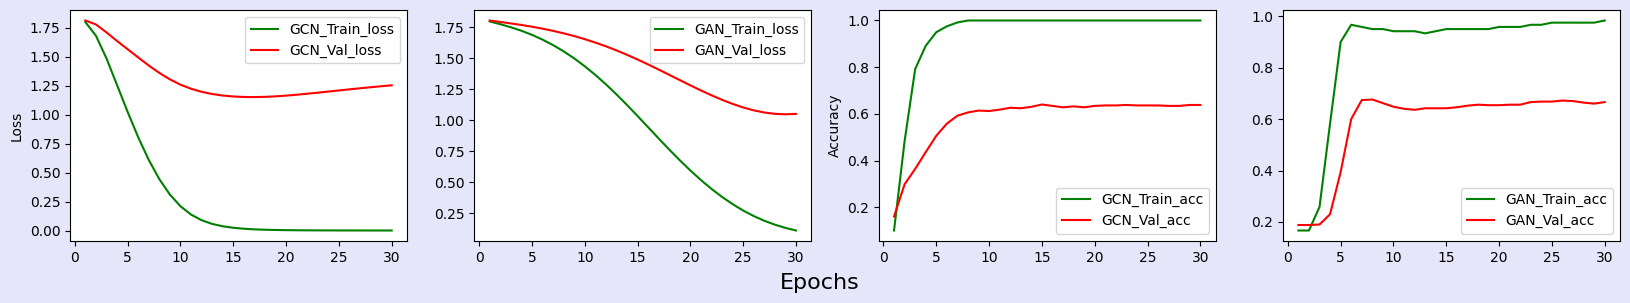

In [89]:
figs, axis = plt.subplots(1, 4, figsize=(20,3), facecolor="lavender")
grids = np.arange(5, 30, 5)

df.iloc[:,0:2].plot(ax=axis[0], color=['green', 'red'], ylabel='Loss')

df.iloc[:,4:6].plot(ax=axis[1], color=['green', 'red'])

df.iloc[:,2:4].plot(ax=axis[2], color=['green', 'red'], ylabel='Accuracy')

df.iloc[:,6:8].plot(ax=axis[3], color=['green', 'red'])

figs.text(0.5, -0.05, 'Epochs', ha='center', size=16)
plt.savefig("charts/training_results.png", dpi=300);

In [90]:
(h1, _), (h2, _) = GCN(X.squeeze(axis=0), A.squeeze(axis=0)), GAN(X, A)

tsne1 = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h1.squeeze(axis=0).detach())
tsne2 = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h2.squeeze(axis=0).detach())

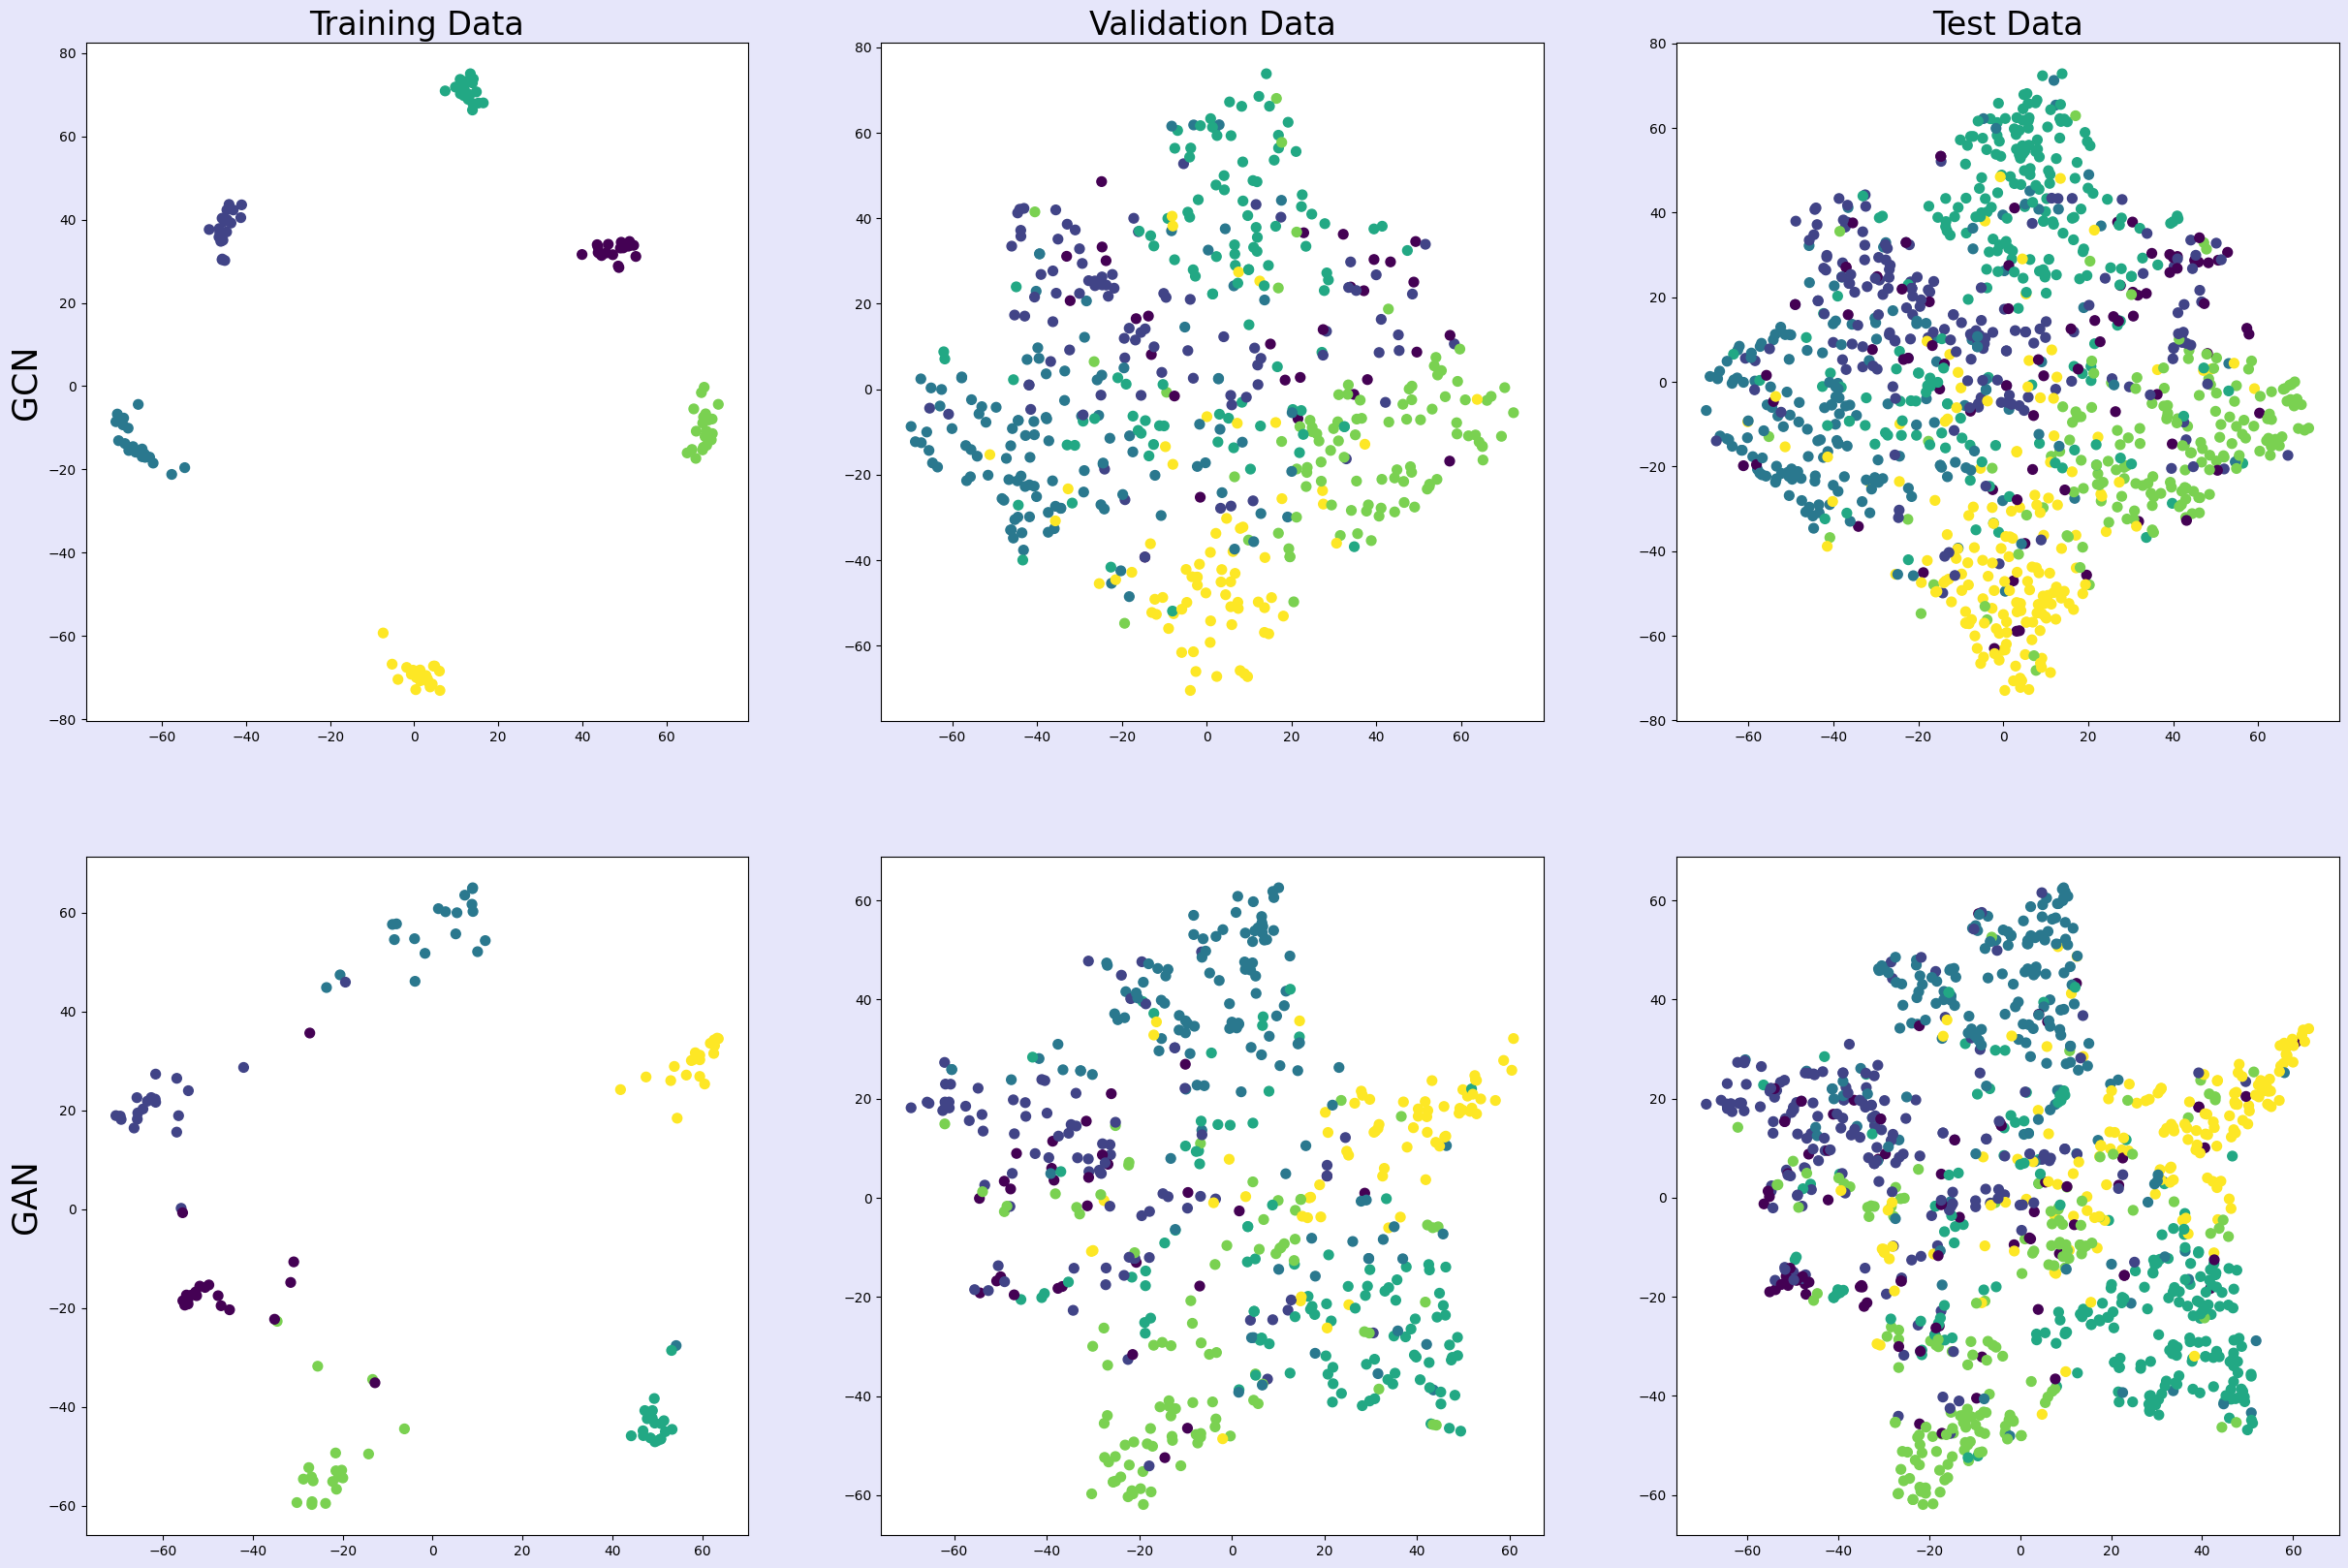

In [147]:
fig, ax = plt.subplots(2,3, figsize=(30, 20), facecolor='lavender')

ax[0,0].set_title("Training Data", size=24)
ax[0,0].scatter(tsne1[data.train_mask][:, 0], tsne1[data.train_mask][:, 1], s=50, c=data.y[data.train_mask])
ax[0,0].set_ylabel('GCN', size=25)

ax[0,1].set_title("Validation Data", size=24)
ax[0,1].scatter(tsne1[data.val_mask][:, 0], tsne1[data.val_mask][:, 1], s=50, c=data.y[data.val_mask])

ax[0,2].set_title("Test Data", size=24)
ax[0,2].scatter(tsne1[data.test_mask][:, 0], tsne1[data.test_mask][:, 1], s=50, c=data.y[data.test_mask])

ax[1,0].scatter(tsne2[data.train_mask][:, 0], tsne2[data.train_mask][:, 1], s=50, c=data.y[data.train_mask])
ax[1,0].set_ylabel('GAN', size=25)

ax[1,1].scatter(tsne2[data.val_mask][:, 0], tsne2[data.val_mask][:, 1], s=50, c=data.y[data.val_mask])

ax[1,2].scatter(tsne2[data.test_mask][:, 0], tsne2[data.test_mask][:, 1], s=50, c=data.y[data.test_mask])
plt.savefig("charts/TSNE.pngdd", dpi=300);